In [ ]:
#default_exp PracticalDeepLearning.Lesson1.Experiments

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Lesson 1 Experiments
> Modifying and testing parameters from the lesson 1 notebook.

# Where we left off
Quickly run the code necessary to get back to where we left off in the coursework.

In [ ]:
#export
from fastai2.data.all import *
from fastai2.vision.all import *
from nbdev.showdoc import *

In [ ]:
#exports
path = untar_data(URLs.PETS)
path_anno, path_img = [path/folder for folder in path.ls()]

fname = get_image_files(path_img)
fname[:5]

In [ ]:
#exports
pat = r'/(\w+)_\d+.jpg'

dblock = DataBlock((ImageBlock,CategoryBlock),
                    splitter=RandomSplitter(),
                    get_items=get_image_files,
                    item_tfms=Resize(224),
                    batch_tfms=aug_transforms(),
                    get_y=RegexLabeller(pat))

dls = dblock.dataloaders(path_img, bs=4)

# Pre Trained Models
To train our model we only need to run the following code. Although it doesn't show it below, fastai chooses what device to run the training on by it's self. If you have a gpu enabled it will automatically grab the first one for training.

In case you don't know if you have your gpu enabled or not simply check with pytorch running the following code.

    import torch
    print(torch.cuda.is_available())

To train all we need to do is pass our dataloaders and a model to the Learner contructor. Usually for basic classification we can just use a resnet architecture around the size of our dataset.

But with just this we won't be able to tell how well our training is going, so we add `metrics=error_rate` which calculates the accuracy we get in the validation set.

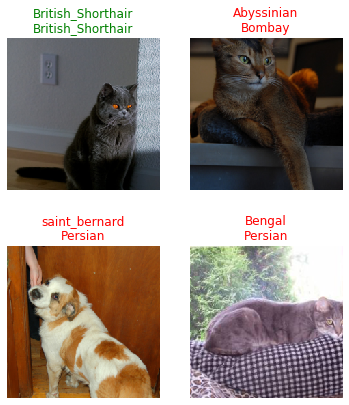

In [ ]:
#show
learner = Learner(dls, resnet34(), metrics=error_rate)
learner.fit(4)
learner.show_results()

Sadly this didn't go to well, with the results we saw above we might as well be guessing. The thing is we were only using the resnet architecture but not the trained parameters. If we use the pretrained version of resnet we can take advantage of the transfer learning which will have better generalized results and converge faster.

If this is the first time using this specific model fastai will download it to your computer. Because of this you will need an internet connection the first time you train. After that you will can simply run the code without having to wait.

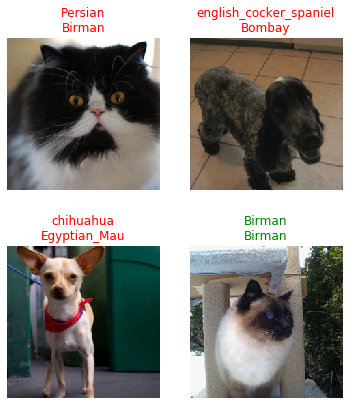

In [ ]:
#show
learner = Learner(dls, resnet34(pretrained=True), metrics=error_rate)
learner.fit(4)
learner.show_results()

But... this still doesn't seem to be enough. We only get slightly better results than before and we even have a spike in our validation loss. This could be better improved with variable tweaks but fastai has an even better training function that will work better.

# Using fastai's fit_one_cycle

One of the reasons fastai has such great out of the box results is because of all of the state of the art best practices that are prebuilt into it's library. Some of them are deeply built inside the library that removing them is very complicated, for example removing the validation set for training.

Here we will look at the one cycle training which resulted from a paper around 2018. One cycle changes the learning rate during training which allows better convergance, which leads to less epochs. This means the neural network sees the data less and this helps avoid overfitting. Lets compair the results from one_cycle training with the results above.

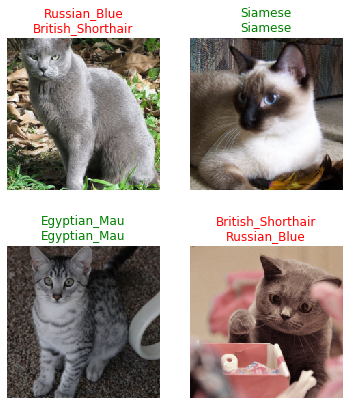

In [ ]:
#show
learner = Learner(dls, resnet34(pretrained=True), metrics=error_rate)
learner.fit_one_cycle(4)
learner.show_results()

In one epoch we already achieved better results than before, not only that but after 3 epochs we achieved better results than the original 2012 paper. This is clearly without much training and even less parameter tweaking, which 

One thing to remember is that the training methods are named differently, which means that you need to be careful not to forget to use fit_one_cycle instead of fit.

# Mixed Precision

Another advancement that happend in the last couple of years is the idea of mixed precision which was studied by Nvidia. There's a conference [video](http://on-demand.gputechconf.com/gtc/2018/video/S81012/) which goes much more into detail, but for now we will only look at the benefits.

- Faster Training (2-4 times faster)
- Light Weight (Using half the memory)
- Enables better batch size, more parameters, bigger resolution data etc...
- No Loss in Weight Precision
- No need to change the architecture

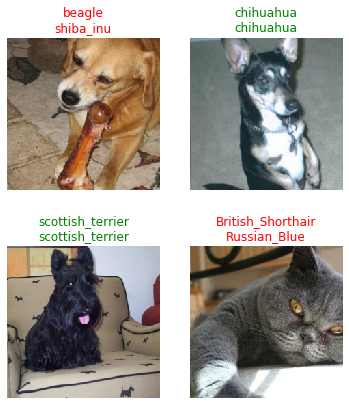

In [ ]:
#show
learner = Learner(dls, resnet34(pretrained=True), metrics=error_rate).to_fp16()
learner.fit_one_cycle(4)
learner.show_results()

For now this didn't give us the faster results we were expecting, but this was run on a standard laptop dedicated gpu. Because of this it's possible that it was unable to take advantage of the function call which made it default back to normal training. Further testing is needed.

# XResNet
In fastaiV2 there is a sudden shift in preferred pretrained convolutional model, from ResNet to XResNet. XResNet seems to be the same architecture trained using the "bag of tricks" augmentations. These are various tricks that generally give better results. This can be better explained in this [article](https://towardsdatascience.com/a-big-of-tricks-for-image-classification-fec41eb28e01).

So the question is, clearly, how does it match up with the results we achieved before? Below are the tests with xresnet34, xresnet34_deep and xresnet_deeper, which as the name describes are simply deeper versions of the resnet architecture.

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /home/holydemon/.cache/torch/checkpoints/xrn50_940.pth
100%|██████████| 244M/244M [01:32<00:00, 2.77MB/s] 


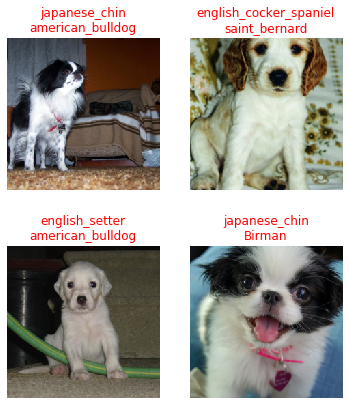

In [ ]:
#show
learner = Learner(dls, xresnet34(pretrained=True), metrics=error_rate).to_fp16()
learner.fit_one_cycle(4)
learner.show_results()

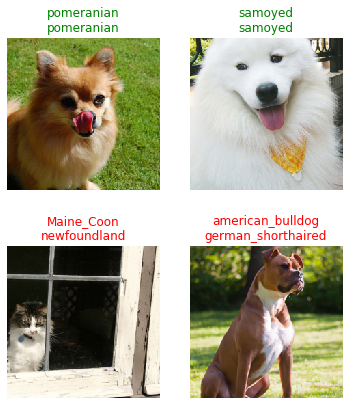

In [ ]:
#show
learner = Learner(dls, xresnet34_deep(pretrained=True), metrics=error_rate).to_fp16()
learner.fit_one_cycle(4)
learner.show_results()

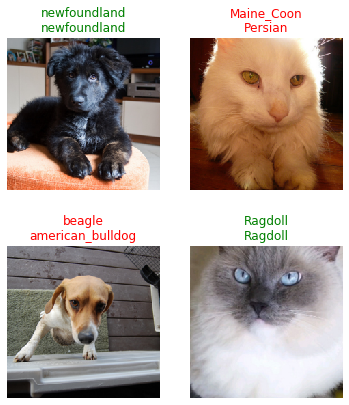

In [ ]:
#show
learner = Learner(dls, xresnet34_deeper(pretrained=True), metrics=error_rate).to_fp16()
learner.fit_one_cycle(4)
learner.show_results()

From the three results we can see that xresnet performs much worse than normal resnet, while the other deeper versions compair more resonably to it. This is, however without any fine tuning, which is what we should explore in the next part.

# Final Notes

Clearly these results are not final, one run for each model and method is not significant enough for most cases especially when working with machine learning. That being said the results do give us quite a good idea about how much better some of these methods are and why fastai uses one over another.